In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext 
sc = SparkContext("local", "App Name")

In [41]:
sql = SQLContext(sc)
df = pd.read_excel("BTC2018.xlsx",sheet_name="BTC2018")
df=sql.createDataFrame(df) 
df.show()

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+------------+------------------+----------------+----------------+---------------------+-------------------------+--------------------+
|      time|       nBits|             value|        in_count|       out_count|current_price (close)|Last_1_hour_price (close)|       Last 1 Change|
+----------+------------+------------------+----------------+----------------+---------------------+-------------------------+--------------------+
|1562169600|3.88200748E8|4.74906120025626E8|2.00838672102504|2.52137449039021|             11181.28|                 11444.71|-0.02301762124160407|
|1562173200|3.88200748E8|  4.656253178696E8|3.42044612170631|2.61877485005728|             11192.32|                 11181.28| 9.87364595108883E-4|
|1562176800|3.88200748E8|3.38546164640487E8|2.05229279976049|2.38965121500923|             11250.72|                 11192.32|0.005217863677950...|
|1562180400|3.88200748E8|2.70926358949036E8|3.50686609502933|2.19708593901102|             11261.69|            

In [42]:
# Features engineering
from pyspark.sql import functions as F
df = (df
    .select(
        F.col('time'),
        F.col(' nBits').alias('nBits'),
        F.col(' value').alias('value'),
        F.round(F.col(' in_count'),2).alias('in_count'),
        F.round(F.col(' out_count'),2).alias('out_count'),
        F.col('Last_1_hour_price (close)').alias('Open'),
        F.col('current_price (close)').alias('Target'),
    )
    )

df.show()

+----------+------------+------------------+--------+---------+--------+--------+
|      time|       nBits|             value|in_count|out_count|    Open|  Target|
+----------+------------+------------------+--------+---------+--------+--------+
|1562169600|3.88200748E8|4.74906120025626E8|    2.01|     2.52|11444.71|11181.28|
|1562173200|3.88200748E8|  4.656253178696E8|    3.42|     2.62|11181.28|11192.32|
|1562176800|3.88200748E8|3.38546164640487E8|    2.05|     2.39|11192.32|11250.72|
|1562180400|3.88200748E8|2.70926358949036E8|    3.51|      2.2|11250.72|11261.69|
|1562184000|3.88200748E8|2.34645959127633E8|    2.06|     2.24|11261.69|11379.83|
|1562187600|3.88200748E8|3.08632136757078E8|    2.06|     2.27|11379.83|11391.41|
|1562191200|3.88200748E8|2.84058384268412E8|    2.19|     2.28|11391.41|11936.46|
|1562194800|3.88200748E8|3.10764670949991E8|    1.85|     2.26|11936.46|11974.56|
|1562198400|3.88200748E8| 3.5702545046942E8|    2.15|     2.61|11974.56|11838.23|
|1562202000|3.88

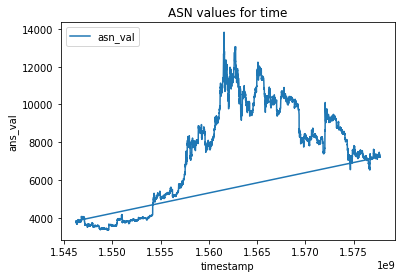

In [69]:
import matplotlib.pyplot as plt

y = [val.Target for val in df.select('Target').collect()]
x = [val.time for val in df.select('time').collect()]

plt.plot(x, y)

plt.ylabel('ans_val')
plt.xlabel('timestamp')
plt.title('ASN values for time')
plt.legend(['asn_val'], loc='upper left')

plt.show()

In [43]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
# assembler = VectorAssembler(inputCols=['dayOfYear', 'dayOfWeek', 'weekOfYear', 'hour', 'year'], outputCol="features")
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'Open'], outputCol="features")
df = assembler.transform(df)
df.show()

+----------+------------+------------------+--------+---------+--------+--------+--------------------+
|      time|       nBits|             value|in_count|out_count|    Open|  Target|            features|
+----------+------------+------------------+--------+---------+--------+--------+--------------------+
|1562169600|3.88200748E8|4.74906120025626E8|    2.01|     2.52|11444.71|11181.28|[1.5621696E9,3.88...|
|1562173200|3.88200748E8|  4.656253178696E8|    3.42|     2.62|11181.28|11192.32|[1.5621732E9,3.88...|
|1562176800|3.88200748E8|3.38546164640487E8|    2.05|     2.39|11192.32|11250.72|[1.5621768E9,3.88...|
|1562180400|3.88200748E8|2.70926358949036E8|    3.51|      2.2|11250.72|11261.69|[1.5621804E9,3.88...|
|1562184000|3.88200748E8|2.34645959127633E8|    2.06|     2.24|11261.69|11379.83|[1.562184E9,3.882...|
|1562187600|3.88200748E8|3.08632136757078E8|    2.06|     2.27|11379.83|11391.41|[1.5621876E9,3.88...|
|1562191200|3.88200748E8|2.84058384268412E8|    2.19|     2.28|11391.41|1

In [50]:
# Split data into training set and testing set
from pyspark.ml.regression import *
# 2020-10-20(1603234800)
X_train = df.filter(F.col('time') < "1563123600")
X_test = df.filter(F.col('time') > "1563123600")
# Applying a gradient boosted tree regressor
gbt = GBTRegressor(labelCol="Target")
fitted = gbt.fit(X_train)
yhat = (fitted.transform(X_test))
yhat.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|10489.79|10384.554487263491|
|10483.56|10572.350277075224|
|10645.65|10513.517153542787|
|10660.42| 10751.05616728616|
|10496.32|10781.973896633583|
| 10195.0|10554.344352344247|
| 10030.9|10478.863743133412|
| 10055.0|10394.914047590524|
|10073.73|10575.271666370189|
| 10260.0|10605.153709609103|
|10170.99|10576.775105497283|
|10179.89| 10495.54180684902|
|10169.01|10513.517153542787|
| 10320.0| 10348.01495725476|
|10185.04| 10501.16363399389|
|10343.93|10645.128785543686|
|10299.57|10510.265071817132|
|10310.99|10485.914835534884|
|10108.54|10394.914047590524|
| 10403.0| 10543.89621246695|
+--------+------------------+
only showing top 20 rows



In [57]:
# Evaluations
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat)
print('RMSE is', rmse)
mae = eval.evaluate(yhat, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 463.0515956082535
MAE is 359.99778483882466
R² is 0.8809583818580367


In [61]:
# Optimise the model with Kfold and GridSearch Method
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8, 10, 12])
             .addGrid(gbt.maxBins, [32, 64])
             .build())
cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=3)  
cvModel = cv.fit(X_train)
cvYhat = cvModel.transform(X_test)

cvEval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = cvEval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = cvEval.evaluate(cvYhat, {cvEval.metricName: "mae"})
print('MAE is', mae)
r2 = cvEval.evaluate(cvYhat, {cvEval.metricName: "r2"})
print('R² is', r2)

cvYhat.select(F.col('Target'), F.col('prediction')).show()

RMSE is 343.5177925750768
MAE is 251.90215796809815
R² is 0.93448533506469
+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|10489.79|10347.700657995316|
|10483.56|10347.700657995316|
|10645.65|10347.700657995316|
|10660.42|10858.206125948089|
|10496.32|10889.910437304667|
| 10195.0|10353.636339631334|
| 10030.9|10347.700657995316|
| 10055.0|10344.830823989583|
|10073.73|10317.726123143171|
| 10260.0|10317.726123143171|
|10170.99| 10348.03806810429|
|10179.89|10300.763332447446|
|10169.01|10347.700657995316|
| 10320.0|10300.763332447446|
|10185.04|10350.069652848642|
|10343.93|10347.700657995316|
|10299.57|10347.700657995316|
|10310.99|10347.700657995316|
|10108.54|10300.763332447446|
| 10403.0|10300.763332447446|
+--------+------------------+
only showing top 20 rows



In [68]:
# Importance of each features in GBTRegressor
score = fitted.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'Open']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.989028
time,0.003256
value,0.002488
out_count,0.002400
in_count,0.001915
nBits,0.000913
